In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

from indicators import get_sma
from utils import get_equity_curve_buy_and_hold, fetch_data

In [3]:
ticker_symbol = "USDEUR=X"   
start_date = "2010-01-01"
end_date = "2025-08-01"
interval = "1d"
data = fetch_data(ticker_symbol, start_date, end_date, interval)

c:\javier\personal_projects\quantitative_trading\quant_sandbox\utils.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yfinance.download(
[*********************100%***********************]  1 of 1 completed


In [6]:
# computing returns and equity curve for buy & hold strategy
data = get_equity_curve_buy_and_hold(data)

# computing features
sma_long = 200
sma_short = 50
data.loc[:, 'sma_short'] = get_sma(data, sma_short)
data.loc[:, 'sma_long'] = get_sma(data, sma_long)

data = data.dropna()

C:\Users\truji\AppData\Local\Temp\ipykernel_10160\1754655522.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  index_last, last_return = strategy_equity_curve.index[-1], strategy_equity_curve[-1]


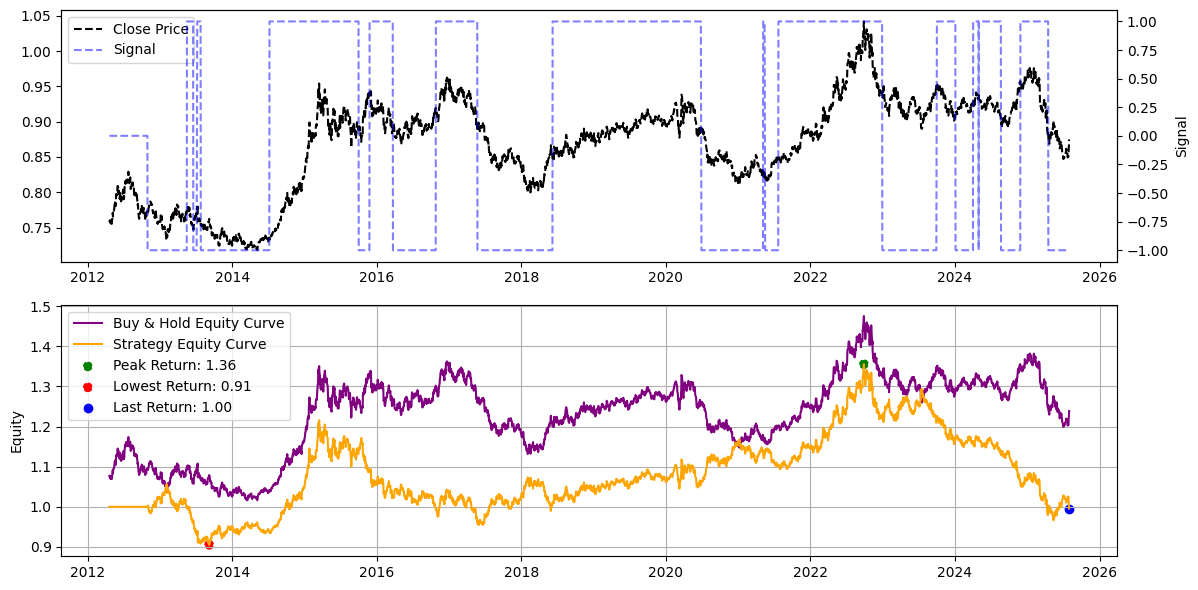

In [12]:
# computing signal
data.loc[data.index[sma_short:], 'signal'] = np.where(
    data.loc[data.index[sma_short:], 'sma_short'] > data.loc[data.index[sma_short:], 'sma_long'], 1, -1
)
first_crossover_idx = data.index[(data['sma_short'] > data['sma_long']).astype(int).diff().fillna(0) != 0][0]
data.loc[:first_crossover_idx, 'signal'] = 0

# assess strategy
strategy_equity_curve = (data['signal'] * data['returns_log']).cumsum().apply(np.exp)

def plot_strategy_performance(data, strategy_equity_curve: pd.Series):
    index_peak, peak_return = strategy_equity_curve.index[strategy_equity_curve.argmax()], strategy_equity_curve.max()
    index_lowest, lowest_return = strategy_equity_curve.index[strategy_equity_curve.argmin()], strategy_equity_curve.min()
    index_last, last_return = strategy_equity_curve.index[-1], strategy_equity_curve[-1]

    fig, (ax, ax_equity) = plt.subplots(2, 1, figsize=(12, 6))
    ax.plot(data['Close'], label='Close Price', color='black', linestyle='--')
    ax2 = ax.twinx()
    ax2.plot(data['signal'], label='Signal', color='blue', linestyle='--', alpha=0.5)
    ax2.set_ylabel('Signal')
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines + lines2, labels + labels2, loc='upper left')

    ax_equity.plot(data.index, data['equity_0'], label='Buy & Hold Equity Curve', color='purple')
    ax_equity.plot(data.index, strategy_equity_curve, label='Strategy Equity Curve', color='orange')
    ax_equity.scatter(index_peak, peak_return, color='green', linestyle='--', label=f'Peak Return: {peak_return:.2f}')
    ax_equity.scatter(index_lowest, lowest_return, color='red', linestyle='--', label=f'Lowest Return: {lowest_return:.2f}')
    ax_equity.scatter(index_last, last_return, color='blue', label=f'Last Return: {last_return:.2f}')
    ax_equity.set_ylabel('Equity')
    ax_equity.legend()
    ax_equity.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_strategy_performance(data, strategy_equity_curve)

In [72]:
strategy_equity_curve.index[strategy_equity_curve.argmax()]

Timestamp('2022-09-28 00:00:00')

In [83]:
from backtesting import Strategy
from backtesting.lib import crossover
from backtesting import Backtest

class SignalStrategy(Strategy):
    def init(self):
        self._indicators.append(self.data.signal)

    def next(self):     
        current_signal = self.data.signal[-1]
        if current_signal == 1:
            if not self.position:
                self.buy()
        elif current_signal == -1:
            if self.position:
                self.position.close()

cash = 10_000
fixed_fee = 1
comission = fixed_fee/cash
bt = Backtest(data, SignalStrategy, cash=cash, commission=0, trade_on_close=True)
stats = bt.run()
bt.plot()

GridPlot(id='p2811', ...)

In [52]:
stats

Start                     2014-10-20 00:00:00
End                       2025-07-31 00:00:00
Duration                   3937 days 00:00:00
Exposure Time [%]                    88.53276
Equity Final [$]                   8210.46727
Equity Peak [$]                   11867.98652
Return [%]                          -17.89533
Buy & Hold Return [%]                -3.85275
Return (Ann.) [%]                    -1.75396
Volatility (Ann.) [%]                 6.92816
CAGR [%]                             -1.25415
Sharpe Ratio                         -0.25316
Sortino Ratio                        -0.33847
Calmar Ratio                         -0.05326
Alpha [%]                           -17.24078
Beta                                  0.16989
Max. Drawdown [%]                   -32.93009
Avg. Drawdown [%]                    -3.96536
Max. Drawdown Duration     2330 days 00:00:00
Avg. Drawdown Duration      210 days 00:00:00
# Trades                                   18
Win Rate [%]                      

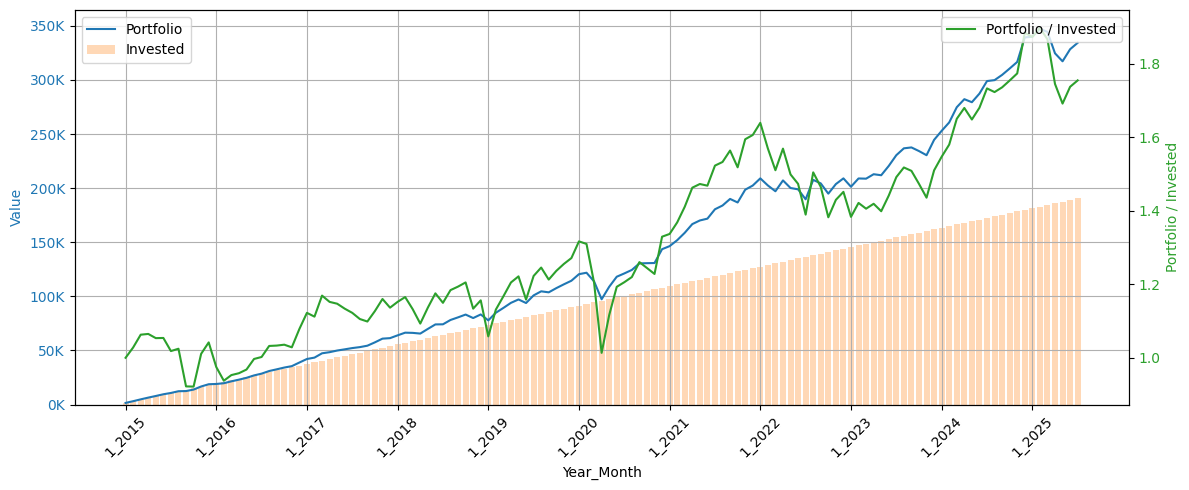

In [ ]:
ftse_data = spy_data

monthly_investment = 1500
num_months = (pd.to_datetime(end_date).year - pd.to_datetime(start_date).year) * 12 + (pd.to_datetime(end_date).month - pd.to_datetime(start_date).month)
ftse_data['M_Y'] = ftse_data.index.month.astype(str) + "_" + ftse_data.index.year.astype(str)

# investing in the first day of the month
first_of_month = ftse_data.groupby('M_Y', sort=False).first()
first_of_month['shares_buy'] = (monthly_investment/first_of_month.Close).cumsum()
first_of_month['portfolio'] = first_of_month['shares_buy'] * first_of_month['Close']
first_of_month['invested'] = monthly_investment*np.ones(first_of_month.shape[0]).cumsum()

from matplotlib.ticker import FuncFormatters

fig, ax1 = plt.subplots(figsize=(12, 5))

color1 = 'tab:blue'
color2 = 'tab:orange'
color3 = 'tab:green'

ax1.set_xlabel('Year_Month')
ax1.set_ylabel('Value', color=color1)
ax1.plot(first_of_month['portfolio'], '-', label='Portfolio', color=color1)
ax1.bar(first_of_month.index, first_of_month['invested'], label='Invested', color=color2, alpha=0.3)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_xticks(range(0, len(first_of_month.index), 12))
ax1.set_xticklabels(list(first_of_month.index)[::12], rotation=45)
ax1.legend(loc='upper left')
def thousands(x, pos):
    return f'{int(x/1000)}K'

ax1.yaxis.set_major_formatter(FuncFormatter(thousands))
ax1.grid(True)

ax2 = ax1.twinx()
ax2.set_ylabel('Portfolio / Invested', color=color3)
ax2.plot(first_of_month['portfolio']/first_of_month['invested'], '-', label='Portfolio / Invested', color=color3)
ax2.tick_params(axis='y', labelcolor=color3)
ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [8]:
%%time

stats = bt.optimize(n1=range(5, 30, 5),
                    n2=range(10, 70, 5),
                    maximize='Equity Final [$]',
                    constraint=lambda param: param.n1 < param.n2)
stats

c:\javier\personal_projects\quantitative_trading\repos\.venv\Lib\site-packages\backtesting\backtesting.py:1624: RuntimeWarning: If you want to use multi-process optimization with `multiprocessing.get_start_method() == 'spawn'` (e.g. on Windows),set `backtesting.Pool = multiprocessing.Pool` (or of the desired context) and hide `bt.optimize()` call behind a `if __name__ == '__main__'` guard. Currently using thread-based paralellism, which might be slightly slower for non-numpy / non-GIL-releasing code. See https://github.com/kernc/backtesting.py/issues/1256
  output = _optimize_grid()
c:\javier\personal_projects\quantitative_trading\repos\.venv\Lib\site-packages\backtesting\backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
c:\javier\personal_projects\quantitative_trading\repos\.venv\Lib\site-packages\backtesting\backtesting.py:1637: UserWarni

CPU times: total: 3.06 s
Wall time: 3.08 s


c:\javier\personal_projects\quantitative_trading\repos\.venv\Lib\site-packages\backtesting\backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
c:\javier\personal_projects\quantitative_trading\repos\.venv\Lib\site-packages\backtesting\backtesting.py:1545: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  stats = self.run(**dict(zip(heatmap.index.names, best_params)))


Start                     2015-01-02 00:00:00
End                       2025-07-31 00:00:00
Duration                   3863 days 00:00:00
Exposure Time [%]                    96.97194
Equity Final [$]                  13814.22389
Equity Peak [$]                   13814.22389
Commissions [$]                     365.91122
Return [%]                           38.14224
Buy & Hold Return [%]               169.46921
Return (Ann.) [%]                     3.05248
Volatility (Ann.) [%]                15.48632
CAGR [%]                              2.13018
Sharpe Ratio                          0.19711
Sortino Ratio                         0.29817
Calmar Ratio                          0.10017
Alpha [%]                            56.91892
Beta                                  -0.1108
Max. Drawdown [%]                   -30.47369
Avg. Drawdown [%]                    -4.54307
Max. Drawdown Duration     1778 days 00:00:00
Avg. Drawdown Duration      111 days 00:00:00
# Trades                          

In [9]:
stats['_strategy']

<Strategy SmaCross(n1=5,n2=15)>

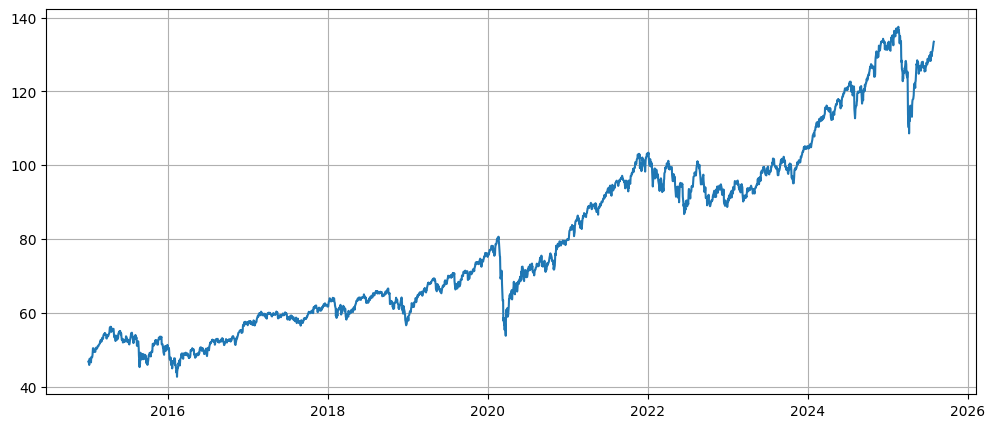

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(spy_data['Close'], '-')
ax.grid()
plt.show()